# Load the datasets 

The following dataset classifies people described by a set of attributes as good or bad credit risks

In [1]:
import numpy as np
import pandas as pd


train_url = "https://gist.githubusercontent.com/ozakbas/18848129885b60398bba6c27e967a09d/raw/6b09c4192f55e1c635d1d171d7253addf6684674/credit_risk_train_data.csv"
test_url = "https://gist.githubusercontent.com/ozakbas/18848129885b60398bba6c27e967a09d/raw/6b09c4192f55e1c635d1d171d7253addf6684674/credit_risk_test_data.csv"

train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

print(train.shape)
print(test.shape)
train.head()

(793, 40)
(207, 40)


,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,f_worker,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,personal_status_male div/sep,personal_status_male mar/wid,personal_status_male single,other_parties_guarantor,other_parties_none,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_yes,label
0,6,1169,4,4,67,2,1.0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1
1,48,5951,2,2,22,1,1.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0
2,12,2096,2,3,49,1,2.0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,1
3,42,7882,2,4,45,1,2.0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1
4,24,4870,3,4,53,2,2.0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 40 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   duration                                       793 non-null    int64  
 1   credit_amount                                  793 non-null    int64  
 2   installment_commitment                         793 non-null    int64  
 3   residence_since                                793 non-null    int64  
 4   age                                            793 non-null    int64  
 5   existing_credits                               793 non-null    int64  
 6   num_dependents                                 709 non-null    float64
 7   f_worker                                       793 non-null    int64  
 8   checking_status_<0                             793 non-null    int64  
 9   checking_status_>=200                          793 non

# Handle missing values

In [3]:
# check if there are any missing values
train.isnull().any()

duration                                         False
credit_amount                                    False
installment_commitment                           False
residence_since                                  False
age                                              False
existing_credits                                 False
num_dependents                                    True
f_worker                                         False
checking_status_<0                               False
checking_status_>=200                            False
checking_status_no checking                      False
credit_history_critical/other existing credit    False
credit_history_delayed previously                False
credit_history_existing paid                     False
credit_history_no credits/all paid               False
savings_status_500<=X<1000                       False
savings_status_<100                              False
savings_status_>=1000                            False
savings_st

In [4]:
value = train['num_dependents'].isnull().sum() / len(train) * 100
print(round(value, 2), "percent of the dependents is missing")

10.59 percent of the dependents is missing


Removing 10% of the data might be too limiting since we have a small dataset. We can impute the missing values with the mean of the column.

In [5]:
train['num_dependents'] = train['num_dependents'].fillna(train['num_dependents'].mean())
test['num_dependents'] = test['num_dependents'].fillna(train['num_dependents'].mean())

# Train decision tree using cross validation

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev


train_label = train.pop('label')
test_label = test.pop('label')

max_depth = [5, 7, 9, 11]
val_accuracies = []

for depth in max_depth:
  tree = DecisionTreeClassifier(max_depth=depth, random_state=10)
  # cv: number of folds
  scores = cross_val_score(tree, train, train_label, cv=5)
  val_accuracies.append(mean(scores))

  print("For max depth = %d, average validation score: %.3f%%" % (depth, mean(scores) * 100)) 
  print("For max depth = %d, standard deviation between each round: %.5f" % (depth, stdev(scores)))

For max depth = 5, average validation score: 70.868%
For max depth = 5, standard deviation between each round: 0.03153
For max depth = 7, average validation score: 69.606%
For max depth = 7, standard deviation between each round: 0.02294
For max depth = 9, average validation score: 71.371%
For max depth = 9, standard deviation between each round: 0.02309
For max depth = 11, average validation score: 69.861%
For max depth = 11, standard deviation between each round: 0.03239


In [7]:
# argmax returns the index of the maximum value
max_depth[np.argmax(val_accuracies)]

9

# Retrain the model with the best max depth value 

In [8]:
best_tree = DecisionTreeClassifier(max_depth=max_depth[np.argmax(val_accuracies)], random_state=2021)
best_tree.fit(train, train_label)

from sklearn.metrics import accuracy_score
preds = best_tree.predict(test)

accuracy = accuracy_score(test_label, preds)
print(accuracy)

0.6811594202898551


# Plot the tree

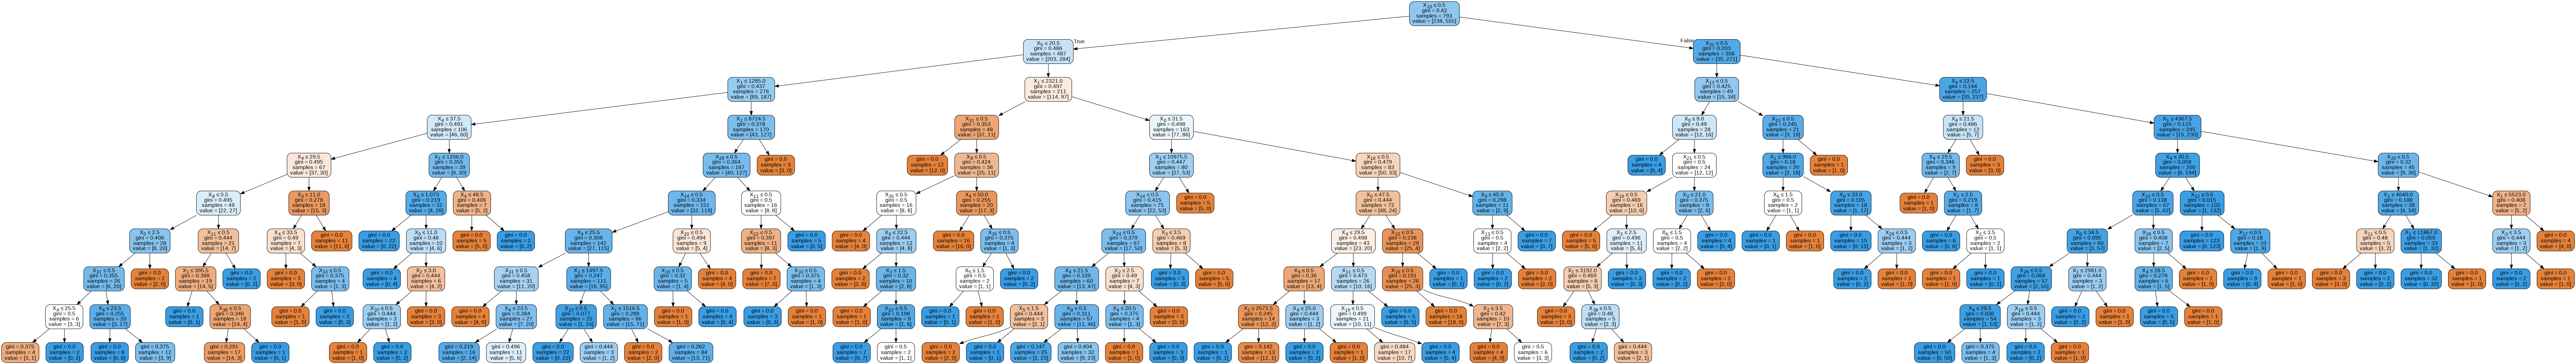

In [9]:
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(best_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())